In [ ]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.layers import Dense
from transformers import TFRobertaForSequenceClassification,RobertaTokenizer
import pickle
from transformers import  AutoConfig,RobertaConfig

In [4]:
import pandas as pd
df = pd.read_csv('yelp_reviews_10000.csv')
df=df.loc[:, ['stars', 'text']]
df

,stars,text
0,3.0,Great crepes. Nice outdoor seating. Cramped s...
1,3.0,wait staff was VERY friendly. hibachi just was...
2,3.0,I recently came here to try out the fried chic...
3,3.0,The was good but the place was a mess! We stop...
4,3.0,Over priced. The plates are too busy. The food...
...,...,...
9995,2.0,"For the price we paid, I was slightly disappoi..."
9996,2.0,Not sure what has happened to this location be...
9997,2.0,Past two times here have been mediocre at best...
9998,2.0,The museum experience was phenomenal. All adul...


In [5]:
def map_sentiment_scores(star_number):
    star_number = int(star_number)
    if star_number == 1:
        return 0
    elif star_number == 2:
        return 1
    elif star_number == 3:
        return 2
    elif star_number == 4:
        return 3
    elif star_number == 5:
        return 4

In [6]:
df['stars'] = df.stars.apply(map_sentiment_scores)
df.head(5)

,stars,text
0,2,Great crepes. Nice outdoor seating. Cramped s...
1,2,wait staff was VERY friendly. hibachi just was...
2,2,I recently came here to try out the fried chic...
3,2,The was good but the place was a mess! We stop...
4,2,Over priced. The plates are too busy. The food...


In [7]:
Text = df['text'].to_list()
labels = df['stars'].to_list()

In [8]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 500

review = Text[0]

tokernizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

inputs = tokernizer(review, max_length=MAX_LEN, truncation=True, padding=True)

print(f'review: \'{review}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

review: 'Great crepes. Nice outdoor seating.  Cramped seating inside.  The staff is marginally friendly to down right rude.'
input ids: [0, 19065, 8633, 29270, 4, 16911, 6185, 14591, 4, 1437, 5309, 16458, 14591, 1025, 4, 1437, 20, 813, 16, 24022, 5192, 7, 159, 235, 21820, 4, 2]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [9]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    return tokernizer(x, max_length=max_len, truncation=trucation, padding=padding)

encodings = construct_encodings(Text, tokernizer, max_len=MAX_LEN)

In [11]:
def construct_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tfdataset = construct_tfdataset(encodings, labels)

In [12]:
TEST_SPLIT = 0.2
BATCH_SIZE = 8

train_size = int(len(Text) * (1-TEST_SPLIT))

tfdataset = tfdataset.shuffle(len(Text))
tfdataset_train = tfdataset.take(train_size)
tfdataset_test = tfdataset.skip(train_size)

tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

In [13]:
dropout_rate = 0.2

In [14]:
config =RobertaConfig.from_pretrained(MODEL_NAME)

In [15]:
config.attention_probs_dropout_prob = dropout_rate  # Set attention dropout rate
config.hidden_dropout_prob = dropout_rate  # Set hidden layer dropout rate
config.num_labels = 5

In [16]:
N_EPOCHS = 5

roberta_model = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, config = config)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [17]:
input_ids_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="input_ids")
attention_mask_layer = tf.keras.layers.Input(shape=(500,), dtype=tf.int32, name="attention_mask")

In [22]:
roberta_output = roberta_model([input_ids_layer, attention_mask_layer])

# Additional Layers after BERT output
dropout_layer = tf.keras.layers.Dropout(0.1)(roberta_output.logits)  # Dropout on BERT output
dense_layer = tf.keras.layers.Dense(128, activation='relu')(dropout_layer)
output = tf.keras.layers.Dense(5, activation='softmax')(dense_layer)

In [23]:
model = tf.keras.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

In [24]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 500)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246494   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    77         'attention_mask[0][0]']      
 SequenceClassification)     5),                                                              

In [26]:
history =model.fit(tfdataset_train,
                   batch_size=BATCH_SIZE,
                   epochs=N_EPOCHS)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1000/1000 [==============================] - 991s 947ms/step - loss: 1.2999 - accuracy: 0.4080
Epoch 2/5
1000/1000 [==============================] - 925s 925ms/step - loss: 1.0269 - accuracy: 0.5518
Epoch 3/5
1000/1000 [==============================] - 922s 922ms/step - loss: 0.9221 - accuracy: 0.6093
Epoch 4/5
1000/1000 [==============================] - 916s 916ms/step - loss: 0.8894 - accuracy: 0.6141
Epoch 5/5
1000/1000 [==============================] - 920s 920ms/step - loss: 0.8146 - accuracy: 0.6510


In [27]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

In [28]:
history_df

,loss,accuracy,epoch
0,1.299881,0.408000,0
1,1.026921,0.551750,1
2,0.922085,0.609250,2
3,0.889427,0.614125,3
4,0.814553,0.651000,4


<Axes: xlabel='epoch'>

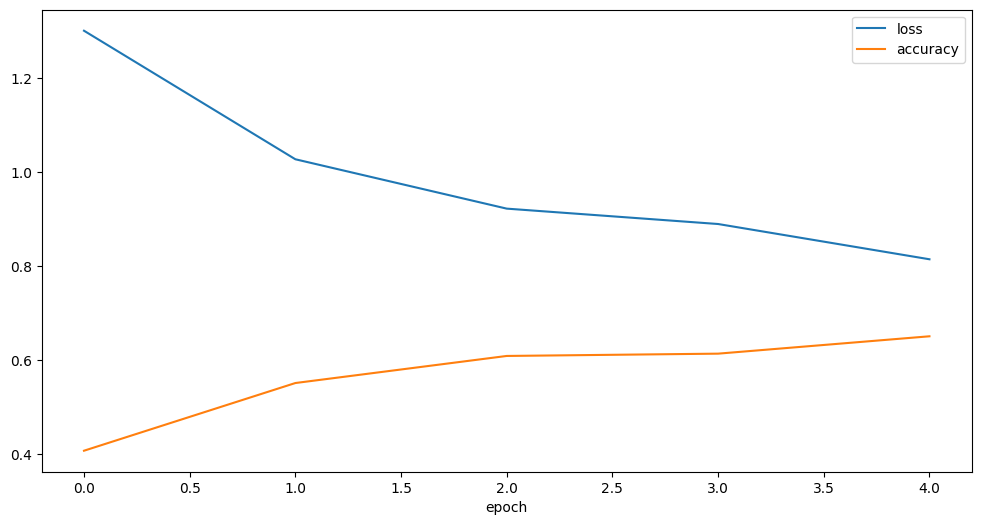

In [29]:
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(12, 6))  # Unpack axes from the tuple

history_df.plot(x="epoch", y=["loss", "accuracy"], ax=ax0)
# history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

In [30]:
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE)
benchmarks

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 82s 316ms/step - loss: 0.6650 - accuracy: 0.7295


{'loss': 0.6649625897407532, 'accuracy': 0.7294999957084656}

In [31]:
import numpy as np

test_text = """Decent poke at an okay price. We got two bowls with sushi rice: salmon and albacore, and salmon and seared cajun tuna.Good: The salmon and tuna were good, and there's a large selection of  mixins and addons -- I consistently get the crab salad, seaweed salad, and tofu skins.
Bad: The albacore was overly salty and many of the pieces were overcooked and rubbery. The sauces are good but I wish there was more added, without having to pay extra."
Overall, nothing spectacular, but Pokeman is an average option in University City"""

test_input = tokernizer(test_text, padding='max_length', truncation=True, max_length=500, return_tensors="tf")

predictions = model.predict(dict(test_input))
print(predictions)


1/1 [==============================] - 3s 3s/step
[[0.03361187 0.4148996  0.53299147 0.01571413 0.00278304]]


In [32]:
predicted_label_index = np.argmax(predictions)
predicted_label_index

2

In [33]:
print("Ratings :" ,float(predicted_label_index + 1 ))

Ratings : 3.0
